<a href="https://colab.research.google.com/github/ajay1808/SpendAtlas/blob/main/SpendAtlas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SpendAtlas Data Processing and Analysis

- [Ajay Kasturirangan](https://ajayrangan.wixsite.com/world)

Opportunity Insights Economic Tracker is a comprehensive tool providing real-time data and analysis on key economic indicators. It offers valuable insights into the dynamic landscape of economic trends and helps inform decision-making processes for businesses and policymakers alike.

Utilizing open-source data from opportunity insights, our analysis focuses on examining the resurgence of consumer spending following the onset of the COVID-19 pandemic, while also investigating potential spatial patterns associated with this rebound.

A [dynamic dashboard](https://ajay1808.github.io/SpendAtlas/dashboard.html) has been deveoped that enables interactive exploration of the data.

## Environment

In [54]:
pip -q install requests pandas install geopandas pysal matplotlib esda libpysal openai

In [2]:
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal as ps
import matplotlib.pyplot as plt
from datetime import datetime
from io import StringIO
from esda.moran import Moran
from libpysal import weights
from libpysal.weights import Queen
from google.colab import drive
import seaborn as sns
import matplotlib.dates as mdates
from scipy import stats
from pandas.plotting import register_matplotlib_converters
import requests
import zipfile
import io
import openai
import time
import re
import os
from decimal import Decimal
from scipy.stats import linregress
from matplotlib.colors import LinearSegmentedColormap

register_matplotlib_converters()
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
folder_path = '/content/gdrive/MyDrive/TIPS_Presentation'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
os.chdir(folder_path)

## Importing Data

In [4]:
def get_csv_urls(user, repo, path):
    base_url = f"https://api.github.com/repos/{user}/{repo}/contents/{path}"
    response = requests.get(base_url)

    if response.status_code == 200:
        files = response.json()
        csv_files = [file for file in files if file['name'].endswith('.csv')]
        csv_urls = [file['download_url'] for file in csv_files]

        return csv_urls
    else:
        print(f"Error: {response.status_code}")
        return []

def get_csv_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = StringIO(response.text)
        df = pd.read_csv(data)
        return df
    else:
        print(f"Error: {response.status_code}")
        return pd.DataFrame()

user = "OpportunityInsights"
repo = "EconomicTracker"
path = "data"

csv_urls = get_csv_urls(user, repo, path)
df_dict = {}

for url in csv_urls:
    df_name = url.split('/')[-1].replace('-','').replace('%20', '_').replace('__','_')
    df = get_csv_data(url)
    df_dict[df_name] = df
    df.to_csv('Data/'+df_name)

<ipython-input-4-b0391dbcdc3b>:19: DtypeWarning: Columns (5,7,16,19,20,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data)


In [5]:
df_dict.keys()

dict_keys(['Affinity_City_Daily.csv', 'Affinity_County_Daily.csv', 'Affinity_National_Daily.csv', 'Affinity_State_Daily.csv', 'Affinity_Daily_Total_Spending_National.csv', 'Affinity_Income_Shares_National_2019.csv', 'Affinity_Income_Shares_National_2020.csv', 'Affinity_Industry_Composition_National_2020.csv', 'COVID_City_Daily.csv', 'COVID_County_Daily_2020.csv', 'COVID_County_Daily_2023.csv', 'COVID_National_Daily.csv', 'COVID_State_Daily.csv', 'Employment_City_Weekly.csv', 'Employment_County_Weekly.csv', 'Employment_National_Weekly.csv', 'Employment_State_Weekly.csv', 'GeoIDs_City.csv', 'GeoIDs_County.csv', 'GeoIDs_State.csv', 'Google_Mobility_City_Daily.csv', 'Google_Mobility_National_Daily.csv', 'Google_Mobility_State_Daily.csv', 'Job_Postings_City_Weekly.csv', 'Job_Postings_County_Weekly.csv', 'Job_Postings_National_Weekly.csv', 'Job_Postings_State_Weekly.csv', 'Policy_Milestones_State.csv', 'UI_Claims_City_Weekly.csv', 'UI_Claims_County_Weekly.csv', 'UI_Claims_National_Weekly.csv

In [6]:
url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip'
response = requests.get(url)
assert response.status_code == 200, f"Request failed with status {response.status_code}"
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall(path='.')

In [7]:
df_dict['Google_Mobility_State_Daily.csv']

,year,month,day,statefips,gps_retail_and_recreation,gps_grocery_and_pharmacy,gps_parks,gps_transit_stations,gps_workplaces,gps_residential,gps_away_from_home
0,2020,2,24,1,0.00286,-0.00714,.0557,.06,0.01290,0.00857,-0.007980
1,2020,2,24,2,0.03000,0.00714,.0629,.0314,0.01570,0.00286,-0.000578
2,2020,2,24,4,0.03140,0.00714,.0543,.04,0.00286,0.00429,-0.007510
3,2020,2,24,5,0.02000,-0.00286,.0286,.00429,0.01570,0.00143,-0.003010
4,2020,2,24,6,0.01290,0.00286,.106,.00714,0.01140,0.00143,-0.002500
...,...,...,...,...,...,...,...,...,...,...,...
49210,2022,10,15,51,-0.09140,0.02290,.709,-.0957,-0.21000,0.03860,-0.040200
49211,2022,10,15,53,-0.09570,-0.02140,.483,-.187,-0.23600,0.03570,-0.037800
49212,2022,10,15,54,0.02710,0.08290,1.16,.32,-0.11700,0.01290,-0.010800
49213,2022,10,15,55,-0.02430,0.09430,.999,-.0314,-0.13300,0.02140,-0.018900


## Gathering relevant Data

We are making use of consumer spending data at the state level

In [8]:
def clean_data(dfn,term,df_dict):    #Converting the data in numerical columns to a usable format
    for df_name in df_dict:
        df = df_dict[df_name]
        if dfn in df_name:
            for col in df.columns:
                if term in col:
                    df[col] = df[col].apply(lambda x: '0' + x if isinstance(x, str) and x.startswith('.') else ('-0' + x[1:] if isinstance(x, str) and x.startswith('-.') else x))
                    df[col] = df[col].apply(lambda x: Decimal(x) if pd.notnull(x) and isinstance(x, str) else x)
                    df[col] = df[col].astype(float)
        df_dict[df_name] = df
clean_data('Affinity','spend',df_dict)

In [9]:
GeoID = df_dict['GeoIDs_State.csv']  #Geographic Data to make connections
GeoID.columns

Index(['statefips', 'statename', 'stateabbrev', 'state_pop2019'], dtype='object')

In [10]:
Spending = df_dict['Affinity_State_Daily.csv']
Spending.columns

Index(['year', 'month', 'day', 'statefips', 'freq', 'spend_all', 'spend_aap',
       'spend_acf', 'spend_aer', 'spend_apg', 'spend_durables',
       'spend_nondurables', 'spend_grf', 'spend_gen', 'spend_hic', 'spend_hcs',
       'spend_inperson', 'spend_inpersonmisc', 'spend_remoteservices',
       'spend_sgh', 'spend_tws', 'spend_retail_w_grocery',
       'spend_retail_no_grocery', 'spend_all_incmiddle', 'spend_all_q1',
       'spend_all_q2', 'spend_all_q3', 'spend_all_q4', 'provisional'],
      dtype='object')

In [11]:
states = gpd.read_file('/content/gdrive/MyDrive/TIPS_Presentation/cb_2018_us_state_500k.shp')
states.drop(['STATENS','AFFGEOID','GEOID','LSAD','ALAND','AWATER'],axis=1,inplace=True)
states.columns

Index(['STATEFP', 'STUSPS', 'NAME', 'geometry'], dtype='object')

In [12]:
policy = df_dict['Policy_Milestones_State.csv']   #Policy Data
policy.columns

Index(['statefips', 'statename', 'date', 'policy_description',
       'schools_first_closed', 'nonessential_biz_first_closed',
       'stayathome_first_start'],
      dtype='object')

## Data Pre-processing

This step is primarily done to get our data ready for the Tableau Dashboard

### Consumer Spending Data

In [13]:
Spending = Spending[Spending['freq'] == 'd']
merged = pd.merge(Spending, GeoID, on='statefips', how='inner')
merged['date'] = pd.to_datetime(merged[['year', 'month', 'day']])
merged['quarter'] = merged['date'].dt.to_period('Q')
spend_columns = [col for col in merged.columns if 'spend' in col]
grouped = merged.groupby(['quarter', 'statefips'])[spend_columns].agg('mean').reset_index().dropna()
states['STATEFP'] = states['STATEFP'].astype(int)
grouped['statefips'] = grouped['statefips'].astype(int)
merged = grouped.merge(states, left_on='statefips', right_on='STATEFP')\
                .dropna()
merged.head(3)

,quarter,statefips,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,spend_durables,spend_nondurables,spend_grf,...,spend_retail_no_grocery,spend_all_incmiddle,spend_all_q1,spend_all_q2,spend_all_q3,spend_all_q4,STATEFP,STUSPS,NAME,geometry
0,2018Q4,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1,AL,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ..."
1,2020Q1,1,-0.031558,-0.124679,-0.099248,-0.081569,-0.044461,-0.013663,-0.005615,0.121662,...,-0.02230,-0.041721,-0.020189,-0.050132,-0.029965,-0.027693,1,AL,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ..."
2,2020Q2,1,-0.134984,-0.267963,-0.424758,-0.477736,-0.144195,0.120095,-0.095241,0.103651,...,0.03097,-0.170316,-0.070842,-0.187129,-0.147042,-0.176032,1,AL,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ..."


In [14]:
spending_categories = ['spend_all', 'spend_aap', 'spend_acf', 'spend_aer', 'spend_apg',
                       'spend_durables', 'spend_nondurables', 'spend_grf', 'spend_gen',
                       'spend_hic', 'spend_hcs', 'spend_inperson', 'spend_inpersonmisc',
                       'spend_remoteservices', 'spend_sgh', 'spend_tws', 'spend_retail_w_grocery',
                       'spend_retail_no_grocery', 'spend_all_incmiddle', 'spend_all_q1',
                       'spend_all_q2', 'spend_all_q3', 'spend_all_q4']

category_names = {'spend_all': 'All merchant category codes',
                  'spend_aap': 'Apparel and accessories',
                  'spend_acf': 'Accomodation and food service',
                  'spend_aer': 'Arts, entertainment, and recreation',
                  'spend_apg': 'General merchandise stores and apparel and accessories',
                  'spend_durables': 'Durable goods',
                  'spend_nondurables': 'Non-durable goods',
                  'spend_grf': 'Grocery and food store',
                  'spend_gen': 'General merchandise stores',
                  'spend_hic': 'Home improvement centers',
                  'spend_hcs': 'Health care and social assistance',
                  'spend_inperson': 'In-person services',
                  'spend_inpersonmisc': 'Other in-person services',
                  'spend_remoteservices': 'Remote services',
                  'spend_sgh': 'Sporting goods and hobby',
                  'spend_tws': 'Transportation and warehousing',
                  'spend_retail_w_grocery': 'Retail including grocery spending',
                  'spend_retail_no_grocery': 'Retail excluding grocery spending',
                  'spend_all_incmiddle': 'Middle-income consumers',
                  'spend_all_q1': 'Quartile 1 income consumers',
                  'spend_all_q2': 'Quartile 2 income consumers',
                  'spend_all_q3': 'Quartile 3 income consumers',
                  'spend_all_q4': 'Quartile 4 income consumers'}
melted_df_spend = merged.melt(id_vars=['quarter', 'NAME', 'statefips'],
                        value_vars=spending_categories,
                        var_name='Spending Category',
                        value_name='Average Spending')
melted_df_spend['Spending Category'] = melted_df_spend['Spending Category'].replace(category_names)
melted_df_spend = melted_df_spend.rename(columns={'NAME': 'State'})
melted_df_spend.head()

,quarter,State,statefips,Spending Category,Average Spending
0,2018Q4,Alabama,1,All merchant category codes,0.000000
1,2020Q1,Alabama,1,All merchant category codes,-0.031558
2,2020Q2,Alabama,1,All merchant category codes,-0.134984
3,2020Q3,Alabama,1,All merchant category codes,-0.008008
4,2020Q4,Alabama,1,All merchant category codes,-0.002917


In [15]:
melted_df_spend.describe()

,statefips,Average Spending
count,12903.000000,12903.000000
mean,28.960784,0.063236
std,15.677443,0.200600
min,1.000000,-0.750813
25%,16.000000,-0.020853
50%,29.000000,0.059708
75%,42.000000,0.181526
max,56.000000,2.154099


In [16]:
from pysal.lib import weights
from pysal.explore import esda

# Create the spatial weights matrix
w = weights.Queen.from_dataframe(states)
w.transform = 'r'

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 27, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 42, ' is an island (no neighbors)')
('WARNING: ', 44, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')


/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 7 islands with ids: 13, 27, 37, 38, 42, 44, 45.
  warnings.warn(message)


In [17]:
islands = w.islands
states_no_islands = states.loc[~states.index.isin(islands)]


w_no_islands = weights.Queen.from_dataframe(states_no_islands)
w_no_islands.transform = 'r'

In [18]:
def calculate_morans(row):
    quarter = row['quarter']
    category = row['Spending Category']

    subset = melted_df_spend[(melted_df_spend['quarter'] == quarter) &
                             (melted_df_spend['Spending Category'] == category)]
    merged_df = states_no_islands.merge(subset, left_on='STATEFP', right_on='statefips')
    moran = esda.Moran(merged_df['Average Spending'], w_no_islands)
    return moran.I
melted_df_spend['Morans I'] = melted_df_spend.apply(calculate_morans, axis=1)

<Axes: xlabel='Morans I', ylabel='Density'>

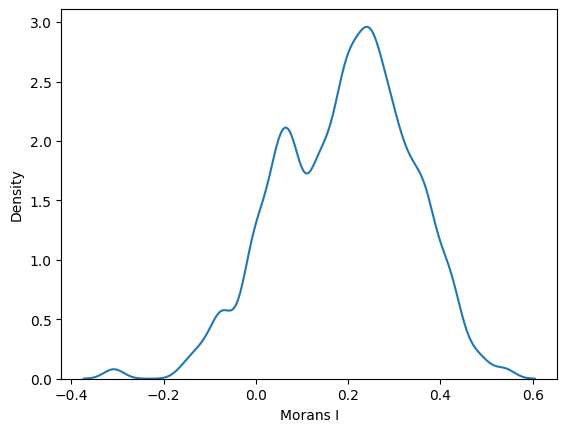

In [19]:
melted_df_spend.dropna(inplace=True)
sns.kdeplot(melted_df_spend['Morans I'])

In [20]:
melted_df_spend.to_csv('/content/gdrive/MyDrive/TIPS_Presentation/Data/Cleaned/consumer_spending.csv',index=False)

### Policy

In [21]:
openai.api_key = 'OPENAI-API-KEY'



def remove_before_capital(s):
    match = re.search(r'[A-Z]', s)
    if match:
        return s[match.start():]
    else:
        return s


def summarize(text):
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f"Please summarize the following text in strictly under 60 words:\n\n{text}",
        temperature=0.2,
        max_tokens= 600
    )
    return remove_before_capital(response.choices[0].text.strip().replace('\n.', '').replace('\n', '').replace('\r', '').strip())

def safe_summarize(text):
    for _ in range(5):
        try:
            return summarize(text)
        except openai.OpenAIError as e:
            print(f"Error: {e}. Retrying...")
            time.sleep(5)
    return None

policy['date'] = pd.to_datetime(policy['date'])
policy['quarter'] = policy['date'].dt.to_period('Q')
policy_grouped = policy.groupby(['quarter'])['policy_description'].apply('. '.join).reset_index()
policy_grouped['summary'] = policy_grouped['policy_description'].apply(safe_summarize)

In [22]:
for i in policy_grouped['summary']:
    print(len(i))

250
738
472
679
323
523
318
425
261
226
105


In [23]:
policy_grouped['summary'][4]

'States across the US have eased restrictions on businesses, social gatherings, and schools, with some lifting capacity restrictions and others allowing in-person instruction. Some states have also issued curfews, while others have declared new states of emergency. Vaccinated individuals have also been given more freedoms.'

In [24]:
policy_grouped.head()

,quarter,policy_description,summary
0,2020Q1,Alabama public schools closed. Alabama ordered...,Wyoming issued stay at home order.Alabama to W...
1,2020Q2,Alabama issued stay at home order. Alabama end...,Wyoming ended stay at home order statewide.Ala...
2,2020Q3,Alabama issued Emergency Order to suspend cert...,"Alabama, Anchorage, Arizona, Arkansas, Califor..."
3,2020Q4,Alaska declared second Public Health Disaster ...,Alaska declared a second Public Health Disaste...
4,2021Q1,Alaska ended Public Health Disaster Emergency ...,States across the US have eased restrictions o...


In [25]:
policy_grouped.to_csv('/content/gdrive/MyDrive/TIPS_Presentation/Data/Cleaned/policy.csv',index=False)

### Geographic Data

In [26]:
states.to_file("/content/gdrive/MyDrive/TIPS_Presentation/Data/Cleaned/States.geojson", driver='GeoJSON')
temp = states.drop('geometry',axis=1)
temp['Join'] = 1
temp.to_csv('/content/gdrive/MyDrive/TIPS_Presentation/Data/Cleaned/States.csv',index=False)

### Time

In [27]:
spend_quarters = melted_df_spend['quarter'].unique()
common_quarters = set(spend_quarters)
df_common_quarters = pd.DataFrame(common_quarters, columns=['quarter'])
df_common_quarters['Year'] = df_common_quarters['quarter'].apply(lambda x: x.year)
df_common_quarters['Start Month'] = df_common_quarters['quarter'].apply(lambda x: x.month)
df_common_quarters['End Month'] = df_common_quarters['quarter'].apply(lambda x: (x.month + 2) % 12 if (x.month + 2) != 12 else 12)

df_common_quarters['Join'] = 1

df_common_quarters.to_csv('/content/gdrive/MyDrive/TIPS_Presentation/Data/Cleaned/common_quarters.csv', index=False)

### Some more preprocessing

In [28]:
melted_df_spend.head()

,quarter,State,statefips,Spending Category,Average Spending,Morans I
1,2020Q1,Alabama,1,All merchant category codes,-0.031558,0.191287
2,2020Q2,Alabama,1,All merchant category codes,-0.134984,0.213348
3,2020Q3,Alabama,1,All merchant category codes,-0.008008,0.339523
4,2020Q4,Alabama,1,All merchant category codes,-0.002917,0.305972
5,2021Q1,Alabama,1,All merchant category codes,0.100733,0.344544


In [29]:
melted_df_spend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11730 entries, 1 to 12902
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype        
---  ------             --------------  -----        
 0   quarter            11730 non-null  period[Q-DEC]
 1   State              11730 non-null  object       
 2   statefips          11730 non-null  int64        
 3   Spending Category  11730 non-null  object       
 4   Average Spending   11730 non-null  float64      
 5   Morans I           11730 non-null  float64      
dtypes: float64(2), int64(1), object(2), period[Q-DEC](1)
memory usage: 641.5+ KB


In [30]:
df = melted_df_spend.copy()
df['quarter'] = df['quarter'].astype(str)
qs = df['quarter'].str.replace(r'(Q\d) (\d+)', r'\2-\1')
df['quarter'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
df['quarter'][:5]

<ipython-input-30-39f7672c1be8>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  qs = df['quarter'].str.replace(r'(Q\d) (\d+)', r'\2-\1')


1   2020-01-01
2   2020-04-01
3   2020-07-01
4   2020-10-01
5   2021-01-01
Name: quarter, dtype: datetime64[ns]

In [31]:
colors = ['#48848b', '#808285', '#e6e6e6', '#CC5500']
sns.set_palette(sns.color_palette(colors))

## Finding Insights

Now lets find some interesting insights in the data that we can explore in the dashboard

### Categories with most increasing Moran's I over time

What is [Moran's index](https://en.wikipedia.org/wiki/Moran%27s_I)?

Moran's I is a measure of spatial autocorrelation, which is a way of determining if there's a pattern in the data that is associated with its spatial location. The index ranges from -1 (indicating perfect dispersion like a chess board) to 1 (indicating perfect correlation), with a value of 0 indicating random spatial distribution. It's commonly used in geography, ecology, and related fields.


In [42]:
categories = df['Spending Category'].unique()
category_slopes = {}

for category in categories:
    temp_df = df[df['Spending Category'] == category]
    slope, _, _, _, _ = linregress(temp_df['quarter'].map(datetime.toordinal), temp_df['Morans I'])
    category_slopes[category] = slope

top_3_categories = sorted(category_slopes, key=category_slopes.get, reverse=True)[:3]

In [43]:
top_3_categories

['Quartile 3 income consumers', 'Durable goods', 'Middle-income consumers']

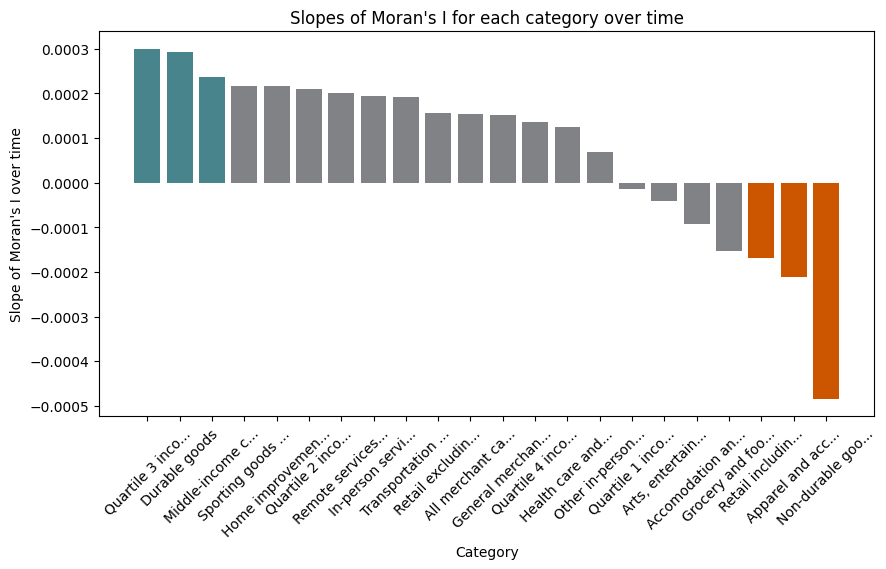

In [44]:
sorted_category_slopes = {k: v for k, v in sorted(category_slopes.items(), key=lambda item: item[1], reverse=True)}

categories = list(sorted_category_slopes.keys())
categories = [category if len(category) < 15 else category[:15] + "..." for category in categories]
slopes = list(sorted_category_slopes.values())

colors = ['#48848b' if category in categories[:3] else '#CC5500' if category in categories[-3:] else '#808285' for category in categories]

plt.figure(figsize=(10,5))
plt.bar(categories, slopes, color=colors)
plt.xticks(rotation=45)
plt.title("Slopes of Moran's I for each category over time")
plt.xlabel('Category')
plt.ylabel('Slope of Moran\'s I over time')
plt.show()

An interesting find here is that Durable goods have a high spatial autocorrelation while non durable goods have negative autocorrelation. Quartile 3 and middle income consumer spending is also relatively highly spatially correlated.

In [45]:
file_path = '/content/gdrive/MyDrive/TIPS_Presentation/Figure1.png'
plt.savefig(file_path, dpi=300)

<Figure size 640x480 with 0 Axes>

### Quarters and Categories with the highest Moran's I

In [46]:
temp = melted_df_spend.groupby(['quarter','Spending Category'])['Morans I'].mean().reset_index(drop=False)
top_3_quarters_categories = temp.nlargest(3, 'Morans I')[['quarter', 'Spending Category', 'Morans I']]
low_3_quarters_categories = temp.nsmallest(3, 'Morans I')[['quarter', 'Spending Category', 'Morans I']]

In [47]:
top_3_quarters_categories

,quarter,Spending Category,Morans I
64,2020Q3,Remote services,0.539248
156,2021Q3,Remote services,0.494361
87,2020Q4,Remote services,0.477082


In [48]:
low_3_quarters_categories

,quarter,Spending Category,Morans I
21,2020Q1,Sporting goods and hobby,-0.308030
114,2021Q1,Transportation and warehousing,-0.153408
186,2022Q1,Apparel and accessories,-0.127660


Interestingly Remote Services has the highest Morans Index. Should be interesting to see how it looks in the [dashboard](https://public.tableau.com/shared/346DCHB9G?:display_count=n&:origin=viz_share_link).

### States with most increase in spending

In [49]:
# States with highest increase in spending
states = melted_df_spend['State'].unique()
state_slopes = {}

for state in states:
    temp_df = df[df['State'] == state]
    slope, _, _, _, _ = linregress(temp_df['quarter'].map(datetime.toordinal), temp_df['Average Spending'])
    state_slopes[state] = slope

top_3_states = sorted(state_slopes, key=state_slopes.get, reverse=True)[:3]

# States with least increase in spending
bottom_3_states = sorted(state_slopes, key=state_slopes.get)[1:4] #Letting go of lowest to remove DC

In [50]:
top_3_states, bottom_3_states

(['Mississippi', 'Massachusetts', 'New Jersey'],
 ['Florida', 'Alaska', 'California'])

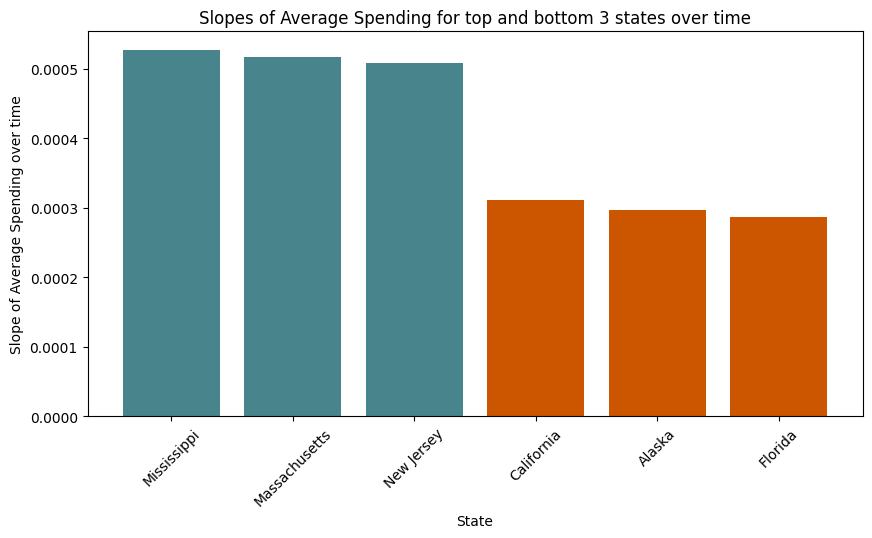

In [51]:
filtered_state_slopes = {state: slope for state, slope in state_slopes.items() if state in top_3_states or state in bottom_3_states}
sorted_state_slopes = {k: v for k, v in sorted(filtered_state_slopes.items(), key=lambda item: item[1], reverse=True)}

states = list(sorted_state_slopes.keys())
slopes = list(sorted_state_slopes.values())
colors = ['#48848b' if state in top_3_states else '#CC5500' for state in states]

plt.figure(figsize=(10,5))
plt.bar(states, slopes, color=colors)
plt.xticks(rotation=45)
plt.title("Slopes of Average Spending for top and bottom 3 states over time")
plt.xlabel('State')
plt.ylabel('Slope of Average Spending over time')
plt.show()

In [52]:
file_path = '/content/gdrive/MyDrive/TIPS_Presentation/Figure2.png'
plt.savefig(file_path, dpi=300)

<Figure size 640x480 with 0 Axes>

## Conclusion

During different stages of the post-COVID recovery, there exist notable patterns in the relationship between spending patterns and spatial autocorrelation. It is important to note that these observations may stem from pure coincidence rather than causation. However, it is worth emphasizing the presence of intermediary forces that drive the spatial correlation and decorrelation of spending among states. Exploring this phenomenon in greater depth promises intriguing insights and potential avenues for further investigation.